This notebook looks at different preprocessing techniques and basic data clensing. 
Based on the cleaned data we have tried various methods to extract features.
We also have tried to test multiple ML/ANN models to test the accuracy on this data.

Next:
    We will look into this data again and try to clean it more so that we can achieve
     better accuracy, recall and precision.

     It is left for user to look into the data closely and crate better corpus.

## Data Preprocessing

In [12]:
## read data

utube_df_a = pd.read_csv('../Data/YoutubeCommentsDataSet.csv')
utube_df = utube_df_a[~utube_df_a.Comment.isnull()].reset_index(drop=True)
# utube_df.head()

In [13]:
## check for class imbalance
utube_df.Sentiment.value_counts(), utube_df_a.Sentiment.value_counts()

(Sentiment
 positive    11402
 neutral      4625
 negative     2337
 Name: count, dtype: int64,
 Sentiment
 positive    11432
 neutral      4638
 negative     2338
 Name: count, dtype: int64)

In [14]:
from nltk.stem.porter import PorterStemmer
stemmer_snowball = PorterStemmer()

utube_corpus_snow = []
rejected_snow = []
for i in range(len(utube_df)):
    try:
        sentance = re.sub("[^a-zA-z]", " ", utube_df['Comment'][i]).lower().split()
        sentance = [stemmer_snowball.stem(word) for word in sentance if word not in stopwords.words('english')]
        sentance = ' '.join(sentance)
        utube_corpus_snow.append(sentance)
    except:
        print(i)
        rejected_snow.append(i)

In [15]:
### use lemmatizer for standardizing the words across
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

utube_corpus = []
rejected = []
for i in range(len(utube_df)):
    try:
        sentance = re.sub("[^a-zA-z]", " ", utube_df['Comment'][i]).lower().split()
        sentance = [lemmatizer.lemmatize(word) for word in sentance if word not in stopwords.words('english')]
        sentance = ' '.join(sentance)
        utube_corpus.append(sentance)
    except:
        print(i)
        rejected.append(i)

## feature creation Using BOW 

In [18]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(max_features=10000, ngram_range=(1,4))
X = cv.fit_transform(utube_corpus).toarray()
Y = utube_df['Sentiment'].astype('category').cat.codes

KeyboardInterrupt: 

In [ ]:
utube_df['Sentiment'].value_counts()

Sentiment
positive    11402
neutral      4625
negative     2337
Name: count, dtype: int64

In [ ]:
#### train, test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, stratify=Y, random_state=0)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((14691, 10000), (3673, 10000), (14691,), (3673,))

In [ ]:
# from imblearn.combine import SMOTEENN
# from collections import Counter

# # Applying SMOTE + ENN
# smote_enn = SMOTEENN(random_state=42)
# X_resampled, y_resampled = smote_enn.fit_resample(X_train, y_train)

# print("Class Distribution After SMOTEENN:", Counter(y_resampled))


In [ ]:
from imblearn.over_sampling import SMOTE
from collections import Counter

# Applying SMOTE + ENN
smote = SMOTE(random_state=42, sampling_strategy='not majority')
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

print("Class Distribution After SMOTEENN:", Counter(y_resampled))


Class Distribution After SMOTEENN: Counter({1: 9121, 2: 9121, 0: 9121})


### 1 - model multinominal logistic regression

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

model_logistic = LogisticRegression(solver='lbfgs', 
                                    multi_class='multinomial', max_iter=500)\
                                        .fit(X_train, y_train)
y_train_pred_prob = model_logistic.predict_proba(X_train)
y_test_pred_prob = model_logistic.predict_proba(X_test)

y_train_pred = model_logistic.predict(X_train)
y_test_pred = model_logistic.predict(X_test)

print(accuracy_score(y_train, y_train_pred), accuracy_score(y_test, y_test_pred))
print('\n')
print(classification_report(y_test, y_test_pred))
print('\n')
print(classification_report(y_train, y_train_pred))

0.955278742086992 0.7451674380615301


              precision    recall  f1-score   support

           0       0.58      0.45      0.50       467
           1       0.58      0.60      0.59       925
           2       0.84      0.87      0.85      2281

    accuracy                           0.75      3673
   macro avg       0.67      0.64      0.65      3673
weighted avg       0.74      0.75      0.74      3673



              precision    recall  f1-score   support

           0       0.98      0.89      0.93      1870
           1       0.91      0.94      0.92      3700
           2       0.97      0.98      0.97      9121

    accuracy                           0.96     14691
   macro avg       0.95      0.93      0.94     14691
weighted avg       0.96      0.96      0.96     14691



### 2 - model Random forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
model_randomforest = RandomForestClassifier(class_weight='balanced', n_estimators=100, criterion='log_loss',
                                            random_state=0).fit(X_train, y_train)

In [ ]:
y_train_pred_prob = model_randomforest.predict_proba(X_train)
y_test_pred_prob = model_randomforest.predict_proba(X_test)

y_train_pred = model_randomforest.predict(X_train)
y_test_pred = model_randomforest.predict(X_test)

print(accuracy_score(y_train, y_train_pred), accuracy_score(y_test, y_test_pred))
print('\n')
print(classification_report(y_test, y_test_pred))
print('\n')
print(classification_report(y_train, y_train_pred))

0.9955755224286978 0.7225701061802341


              precision    recall  f1-score   support

           0       0.58      0.26      0.36       467
           1       0.60      0.53      0.56       925
           2       0.77      0.90      0.83      2281

    accuracy                           0.72      3673
   macro avg       0.65      0.56      0.58      3673
weighted avg       0.70      0.72      0.70      3673



              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1870
           1       0.98      1.00      0.99      3700
           2       1.00      0.99      1.00      9121

    accuracy                           1.00     14691
   macro avg       0.99      1.00      1.00     14691
weighted avg       1.00      1.00      1.00     14691



### 3 - model multinominal XGBoost

In [ ]:
class_counts = np.bincount(Y)  # Get number of samples per class
total_samples = len(Y)  # Total number of samples

# Compute class-wise weights
class_weights = {i: (total_samples - class_counts[i]) / class_counts[i] for i in range(len(class_counts))}
max_weight = max(class_weights.values())
print("Class Weights:", class_weights)

# Assign sample weights based on class
sample_weights = np.array([class_weights[label] for label in y_train])

Class Weights: {0: np.float64(6.857937526743688), 1: np.float64(2.9705945945945946), 2: np.float64(0.6105946325206104)}


In [ ]:
from xgboost import XGBClassifier

# XGBoost with class weight adjustment
xgb_model = XGBClassifier(objective='multi:softmax', num_class=len(class_counts), scale_pos_weight=max_weight)
xgb_model.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None, num_class=3,
              num_parallel_tree=None, ...)

In [ ]:
y_train_pred = xgb_model.predict(X_train)
y_test_pred = xgb_model.predict(X_test)

In [ ]:
print(accuracy_score(y_test, y_test_pred))
print("\n\n")
print(classification_report(y_test, y_test_pred))
print("\n\n")
print(classification_report(y_train, y_train_pred))

0.7394500408385516



              precision    recall  f1-score   support

           0       0.64      0.30      0.41       467
           1       0.58      0.63      0.60       925
           2       0.82      0.87      0.84      2281

    accuracy                           0.74      3673
   macro avg       0.68      0.60      0.62      3673
weighted avg       0.73      0.74      0.73      3673




              precision    recall  f1-score   support

           0       0.93      0.48      0.63      1870
           1       0.70      0.78      0.74      3700
           2       0.87      0.91      0.89      9121

    accuracy                           0.82     14691
   macro avg       0.83      0.73      0.75     14691
weighted avg       0.83      0.82      0.82     14691



### 4 - using back propogation with ANN

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam, RMSprop

In [ ]:
### update data for keras
y_train_k = keras.utils.to_categorical(y_train, num_classes=3)
y_train_k_resampled = keras.utils.to_categorical(y_resampled, num_classes=3)
y_test_k = keras.utils.to_categorical(y_test, num_classes=3)

In [ ]:
model_ann = Sequential()
model_ann.add(Dense(1000, activation='relu', input_shape=(X_train.shape[1],)))
model_ann.add(Dropout(0.1))
model_ann.add(Dense(200, activation='relu'))
model_ann.add(Dropout(0.1))
model_ann.add(Dense(3, activation='softmax'))
model_ann.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 1000)           │    10,001,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 200)            │       200,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 3)              │           603 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,201,803 (38.92 MB)

 Trainable params: 10,201,803 (38.92 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model_ann.compile(optimizer=RMSprop(),
            loss='categorical_crossentropy',
            metrics=['accuracy'])

In [ ]:
history = model_ann.fit(X_train, y_train_k, 
                    epochs=10, batch_size=32, 
                    validation_data=(X_test, y_test),
                    verbose=1)

Epoch 1/10
460/460 ━━━━━━━━━━━━━━━━━━━━ 34s 70ms/step - accuracy: 0.6873 - loss: 0.7267 - val_accuracy: 0.7531 - val_loss: 0.5865
Epoch 2/10
460/460 ━━━━━━━━━━━━━━━━━━━━ 31s 68ms/step - accuracy: 0.8516 - loss: 0.3800 - val_accuracy: 0.7533 - val_loss: 0.6673
Epoch 3/10
460/460 ━━━━━━━━━━━━━━━━━━━━ 32s 69ms/step - accuracy: 0.9315 - loss: 0.1901 - val_accuracy: 0.7484 - val_loss: 0.8697
Epoch 4/10
460/460 ━━━━━━━━━━━━━━━━━━━━ 31s 68ms/step - accuracy: 0.9702 - loss: 0.0909 - val_accuracy: 0.7512 - val_loss: 1.2347
Epoch 5/10
460/460 ━━━━━━━━━━━━━━━━━━━━ 31s 68ms/step - accuracy: 0.9842 - loss: 0.0577 - val_accuracy: 0.7473 - val_loss: 1.4716
Epoch 6/10
460/460 ━━━━━━━━━━━━━━━━━━━━ 31s 68ms/step - accuracy: 0.9900 - loss: 0.0338 - val_accuracy: 0.7473 - val_loss: 1.7080
Epoch 7/10
460/460 ━━━━━━━━━━━━━━━━━━━━ 31s 68ms/step - accuracy: 0.9908 - loss: 0.0318 - val_accuracy: 0.7493 - val_loss: 1.9114
Epoch 8/10
460/460 ━━━━━━━━━━━━━━━━━━━━ 32s 70ms/step - accuracy: 0.9934 - loss: 0.0234 - 

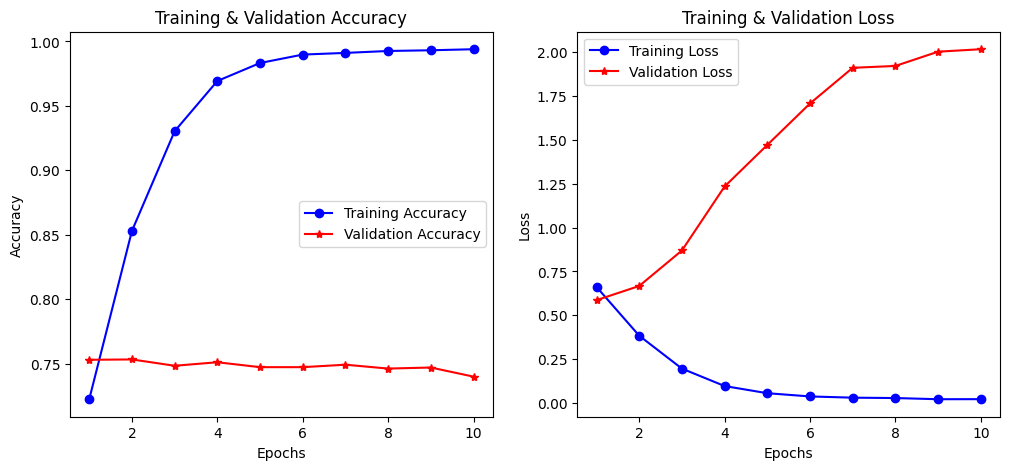

In [ ]:
epochs = range(1, len(history.history['accuracy']) + 1)
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot Accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_acc, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r*-', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training & Validation Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'r*-', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()

plt.show()

In [ ]:
y_train_pred = model_ann.predict(X_train)
y_train_pred = np.argmax(y_train_pred, axis=1) 
y_test_pred = model_ann.predict(X_test)
y_test_pred = np.argmax(y_test_pred, axis=1)

y_test_labels = np.argmax(y_test_k, axis=1)
y_train_labels = np.argmax(y_train_k, axis=1)

print(accuracy_score(y_test, y_test_pred))
print("\n\n")
print(classification_report(y_test_labels, y_test_pred))
print("\n\n")
print(classification_report(y_train_labels, y_train_pred))

460/460 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
0.7399945548597876



              precision    recall  f1-score   support

           0       0.50      0.60      0.55       467
           1       0.57      0.63      0.60       925
           2       0.89      0.81      0.85      2281

    accuracy                           0.74      3673
   macro avg       0.65      0.68      0.67      3673
weighted avg       0.76      0.74      0.75      3673




              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1870
           1       0.98      1.00      0.99      3700
           2       1.00      0.99      1.00      9121

    accuracy                           0.99     14691
   macro avg       0.99      1.00      0.99     14691
weighted avg       0.99      0.99      0.99     14691



## feature creation using Word2Vec model

In [37]:
#### first, lets train word2vec model using our data.
from gensim.models import Word2Vec

## break sentances in list of words.
sentances_to_word = [x.split() for x in utube_corpus]

# Train Word2Vec model
word2vec_model = Word2Vec(sentances_to_word, vector_size=100, window=5, min_count=1, workers=4)

# Save model (Optional)
word2vec_model.save("word2vec.model")


In [40]:
### feature creation
import gensim.downloader as api
from gensim.models import KeyedVectors

# Download and Load Pretrained Google News Word2Vec Model (300-Dimensional)
word2vec_model_google = api.load("word2vec-google-news-300")

# Check Word Vector for "learning"
# print(word2vec_model['learning'][:10])  # Print first 10 dimensions


In [42]:
def get_sentence_vector(sentence, model):
    words = sentence.split()  # Tokenize sentence
    word_vectors = [model[word] for word in words if word in model]
    return np.mean(word_vectors, axis=0) if word_vectors else np.zeros(model.vector_size)


In [44]:
X = np.array([get_sentence_vector(sent, word2vec_model_google) for sent in utube_corpus])
Y = utube_df['Sentiment'].astype('category').cat.codes
X.shape, Y.shape

((18364, 300), (18364,))

In [45]:
#### train, test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, stratify=Y, random_state=0)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((14691, 300), (3673, 300), (14691,), (3673,))

In [46]:
from imblearn.over_sampling import SMOTE
from collections import Counter

# Applying SMOTE + ENN
smote = SMOTE(random_state=42, sampling_strategy='not majority')
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

print("Class Distribution After SMOTEENN:", Counter(y_resampled))


Class Distribution After SMOTEENN: Counter({1: 9121, 2: 9121, 0: 9121})


#### 1 - model using logistic regression

In [47]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

model_logistic = LogisticRegression(solver='lbfgs', 
                                    multi_class='multinomial', max_iter=500)\
                                        .fit(X_train, y_train)
y_train_pred_prob = model_logistic.predict_proba(X_train)
y_test_pred_prob = model_logistic.predict_proba(X_test)

y_train_pred = model_logistic.predict(X_train)
y_test_pred = model_logistic.predict(X_test)

print(accuracy_score(y_train, y_train_pred), accuracy_score(y_test, y_test_pred))
print('\n')
print(classification_report(y_test, y_test_pred))
print('\n')
print(classification_report(y_train, y_train_pred))

0.7804097746919882 0.7571467465287232


              precision    recall  f1-score   support

           0       0.64      0.48      0.55       467
           1       0.62      0.57      0.60       925
           2       0.82      0.89      0.85      2281

    accuracy                           0.76      3673
   macro avg       0.70      0.65      0.67      3673
weighted avg       0.75      0.76      0.75      3673



              precision    recall  f1-score   support

           0       0.68      0.50      0.58      1870
           1       0.68      0.61      0.64      3700
           2       0.83      0.91      0.87      9121

    accuracy                           0.78     14691
   macro avg       0.73      0.67      0.69     14691
weighted avg       0.77      0.78      0.77     14691



#### 2 - model using XGBoost

In [49]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam, RMSprop

In [50]:
### update data for keras
y_train_k = keras.utils.to_categorical(y_train, num_classes=3)
y_train_k_resampled = keras.utils.to_categorical(y_resampled, num_classes=3)
y_test_k = keras.utils.to_categorical(y_test, num_classes=3)

In [60]:
y_train_k.shape

(14691, 3)

In [59]:
model_ann = Sequential()
model_ann.add(Dense(300, activation='relu', input_shape=(300,)))
# model_ann.add(Dropout(0.1))
model_ann.add(Dense(50, activation='relu'))
# model_ann.add(Dropout(0.1))
model_ann.add(Dense(3, activation='softmax'))
model_ann.summary()

model_ann.compile(optimizer=RMSprop(),
            loss='categorical_crossentropy',
            metrics=['accuracy'])



Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_12 (Dense)                │ (None, 300)            │        90,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 50)             │        15,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 3)              │           153 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 105,503 (412.12 KB)

 Trainable params: 105,503 (412.12 KB)

 Non-trainable params: 0 (0.00 B)

In [63]:
### model train
history = model_ann.fit(X_train, y_train_k, 
                    epochs=10, batch_size=32, 
                    validation_data=(X_test, y_test_k),
                    verbose=1)

Epoch 1/10
460/460 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8293 - loss: 0.4201 - val_accuracy: 0.7650 - val_loss: 0.5766
Epoch 2/10
460/460 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8436 - loss: 0.3838 - val_accuracy: 0.7631 - val_loss: 0.6179
Epoch 3/10
460/460 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8612 - loss: 0.3440 - val_accuracy: 0.7770 - val_loss: 0.6319
Epoch 4/10
460/460 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8778 - loss: 0.3114 - val_accuracy: 0.7659 - val_loss: 0.6460
Epoch 5/10
460/460 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8966 - loss: 0.2738 - val_accuracy: 0.7539 - val_loss: 0.7237
Epoch 6/10
460/460 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9117 - loss: 0.2405 - val_accuracy: 0.7544 - val_loss: 0.7906
Epoch 7/10
460/460 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9234 - loss: 0.2069 - val_accuracy: 0.7566 - val_loss: 0.8453
Epoch 8/10
460/460 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9292 - loss: 0.1891 - val_accuracy: 0.

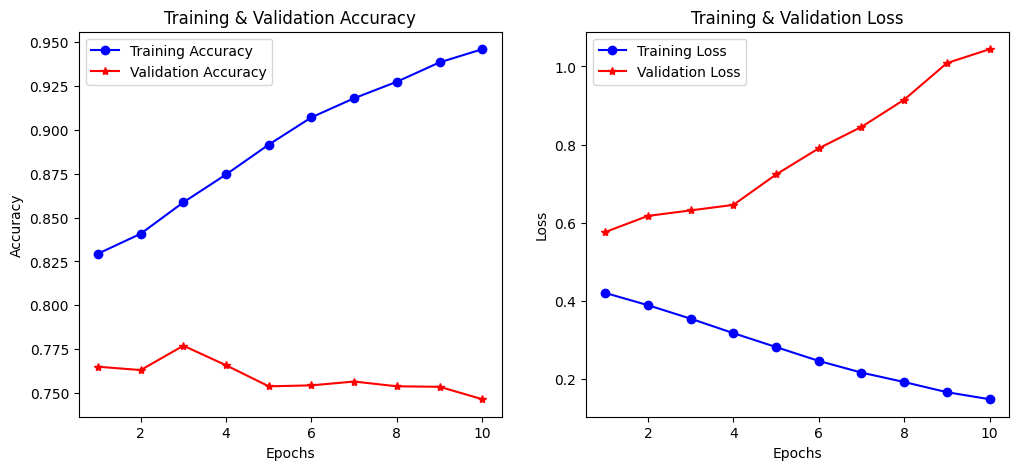

In [64]:
epochs = range(1, len(history.history['accuracy']) + 1)
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot Accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_acc, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r*-', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training & Validation Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'r*-', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()

plt.show()

In [65]:
y_train_pred = model_ann.predict(X_train)
y_train_pred = np.argmax(y_train_pred, axis=1) 
y_test_pred = model_ann.predict(X_test)
y_test_pred = np.argmax(y_test_pred, axis=1)

y_test_labels = np.argmax(y_test_k, axis=1)
y_train_labels = np.argmax(y_train_k, axis=1)

print(accuracy_score(y_test, y_test_pred))
print("\n\n")
print(classification_report(y_test_labels, y_test_pred))
print("\n\n")
print(classification_report(y_train_labels, y_train_pred))

460/460 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
0.7465287231146202



              precision    recall  f1-score   support

           0       0.65      0.45      0.53       467
           1       0.54      0.73      0.62       925
           2       0.88      0.81      0.85      2281

    accuracy                           0.75      3673
   macro avg       0.69      0.66      0.67      3673
weighted avg       0.77      0.75      0.75      3673




              precision    recall  f1-score   support

           0       0.98      0.85      0.91      1870
           1       0.85      0.98      0.91      3700
           2       0.99      0.95      0.97      9121

    accuracy                           0.95     14691
   macro avg       0.94      0.93      0.93     14691
weighted avg       0.95      0.95      0.95     14691

